<a href="https://colab.research.google.com/github/AkankshaSingh2215/MachineLearning/blob/master/MRS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#importing all the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#upload dataset
df = pd.read_csv('https://query.data.world/s/uikepcpffyo2nhig52xxeevdialfl7')

In [5]:
#datafeame's head
df.head(5)

,Unnamed: 0,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,Language,Country,Awards,Poster,Ratings.Source,Ratings.Value,Metascore,imdbRating,imdbVotes,imdbID,Type,tomatoMeter,tomatoImage,tomatoRating,tomatoReviews,tomatoFresh,tomatoRotten,tomatoConsensus,tomatoUserMeter,tomatoUserRating,tomatoUserReviews,tomatoURL,DVD,BoxOffice,Production,Website,Response
0,1,The Shawshank Redemption,1994,R,14 Oct 1994,142 min,"Crime, Drama",Frank Darabont,"Stephen King (short story ""Rita Hayworth and S...","Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",Two imprisoned men bond over a number of years...,English,USA,Nominated for 7 Oscars. Another 19 wins & 30 n...,https://images-na.ssl-images-amazon.com/images...,Internet Movie Database,9.3/10,80.0,9.3,"1,825,626",tt0111161,movie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.rottentomatoes.com/m/shawshank_rede...,27 Jan 1998,NaN,Columbia Pictures,NaN,True
1,2,The Godfather,1972,R,24 Mar 1972,175 min,"Crime, Drama",Francis Ford Coppola,"Mario Puzo (screenplay), Francis Ford Coppola ...","Marlon Brando, Al Pacino, James Caan, Richard ...",The aging patriarch of an organized crime dyna...,"English, Italian, Latin",USA,Won 3 Oscars. Another 23 wins & 27 nominations.,https://images-na.ssl-images-amazon.com/images...,Internet Movie Database,9.2/10,100.0,9.2,"1,243,444",tt0068646,movie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.rottentomatoes.com/m/godfather/,09 Oct 2001,NaN,Paramount Pictures,http://www.thegodfather.com,True
2,3,The Godfather: Part II,1974,R,20 Dec 1974,202 min,"Crime, Drama",Francis Ford Coppola,"Francis Ford Coppola (screenplay), Mario Puzo ...","Al Pacino, Robert Duvall, Diane Keaton, Robert...",The early life and career of Vito Corleone in ...,"English, Italian, Spanish, Latin, Sicilian",USA,Won 6 Oscars. Another 10 wins & 20 nominations.,https://images-na.ssl-images-amazon.com/images...,Internet Movie Database,9.0/10,85.0,9.0,"856,870",tt0071562,movie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.rottentomatoes.com/m/godfather_part...,24 May 2005,NaN,Paramount Pictures,http://www.thegodfather.com/,True
3,4,The Dark Knight,2008,PG-13,18 Jul 2008,152 min,"Action, Crime, Drama",Christopher Nolan,"Jonathan Nolan (screenplay), Christopher Nolan...","Christian Bale, Heath Ledger, Aaron Eckhart, M...",When the menace known as the Joker emerges fro...,"English, Mandarin","USA, UK",Won 2 Oscars. Another 151 wins & 153 nominations.,https://images-na.ssl-images-amazon.com/images...,Internet Movie Database,9.0/10,82.0,9.0,"1,802,351",tt0468569,movie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.rottentomatoes.com/m/the_dark_knight/,09 Dec 2008,"$533,316,061",Warner Bros. Pictures/Legendary,http://thedarkknight.warnerbros.com/,True
4,5,12 Angry Men,1957,APPROVED,01 Apr 1957,96 min,"Crime, Drama",Sidney Lumet,"Reginald Rose (story), Reginald Rose (screenplay)","Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",A jury holdout attempts to prevent a miscarria...,English,USA,Nominated for 3 Oscars. Another 16 wins & 8 no...,https://images-na.ssl-images-amazon.com/images...,Internet Movie Database,8.9/10,96.0,8.9,"494,215",tt0050083,movie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.rottentomatoes.com/m/1000013-12_ang...,06 Mar 2001,NaN,Criterion Collection,http://www.criterion.com/films/27871-12-angry-men,True


In [4]:
#dataframe's last 5 rows
df.tail(5)

,Unnamed: 0,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,Language,Country,Awards,Poster,Ratings.Source,Ratings.Value,Metascore,imdbRating,imdbVotes,imdbID,Type,tomatoMeter,tomatoImage,tomatoRating,tomatoReviews,tomatoFresh,tomatoRotten,tomatoConsensus,tomatoUserMeter,tomatoUserRating,tomatoUserReviews,tomatoURL,DVD,BoxOffice,Production,Website,Response
245,246,The Lost Weekend,1945,NOT RATED,01 Jan 1946,101 min,"Drama, Film-Noir",Billy Wilder,"Charles R. Jackson (from the novel by), Charle...","Ray Milland, Jane Wyman, Phillip Terry, Howard...",The desperate life of a chronic alcoholic is f...,English,USA,Won 4 Oscars. Another 12 wins & 3 nominations.,https://images-na.ssl-images-amazon.com/images...,Internet Movie Database,8.0/10,NaN,8.0,"26,834",tt0037884,movie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.rottentomatoes.com/m/lost_weekend/,06 Feb 2001,NaN,Paramount Pictures,NaN,True
246,247,Short Term 12,2013,R,23 Aug 2013,96 min,Drama,Destin Daniel Cretton,Destin Daniel Cretton,"Brie Larson, John Gallagher Jr., Stephanie Bea...",A 20-something supervising staff member of a r...,English,USA,35 wins & 70 nominations.,https://images-na.ssl-images-amazon.com/images...,Internet Movie Database,8.0/10,82.0,8.0,"62,348",tt2370248,movie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.rottentomatoes.com/m/short_term_12_...,14 Jan 2014,NaN,Cinedigm,http://shortterm12.com,True
247,248,His Girl Friday,1940,APPROVED,18 Jan 1940,92 min,"Comedy, Drama, Romance",Howard Hawks,"Charles Lederer (screen play), Ben Hecht (from...","Cary Grant, Rosalind Russell, Ralph Bellamy, G...",A newspaper editor uses every trick in the boo...,"English, French",USA,2 wins.,https://images-na.ssl-images-amazon.com/images...,Internet Movie Database,8.0/10,NaN,8.0,"43,551",tt0032599,movie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.rottentomatoes.com/m/his_girl_friday/,28 Dec 2004,NaN,Columbia Pictures,NaN,True
248,249,The Straight Story,1999,G,03 Nov 1999,112 min,"Biography, Drama",David Lynch,"John Roach, Mary Sweeney","Sissy Spacek, Jane Galloway Heitz, Joseph A. C...",An old man makes a long journey by lawn-mover ...,English,"France, UK, USA",Nominated for 1 Oscar. Another 14 wins & 37 no...,https://images-na.ssl-images-amazon.com/images...,Internet Movie Database,8.0/10,86.0,8.0,"67,045",tt0166896,movie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.rottentomatoes.com/m/straight_story/,07 Nov 2000,NaN,Buena Vista Pictures,http://disney.go.com/DisneyPictures/straightst...,True
249,250,Slumdog Millionaire,2008,R,25 Dec 2008,120 min,Drama,"Danny Boyle, Loveleen Tandan","Simon Beaufoy (screenplay), Vikas Swarup (novel)","Dev Patel, Saurabh Shukla, Anil Kapoor, Raj Zu...",A Mumbai teen reflects on his upbringing in th...,"English, Hindi, French","UK, France, USA",Won 8 Oscars. Another 144 wins & 126 nominations.,https://images-na.ssl-images-amazon.com/images...,Internet Movie Database,8.0/10,86.0,8.0,"679,975",tt1010048,movie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://www.rottentomatoes.com/m/slumdog_millio...,31 Mar 2009,"$141,243,551",Fox Searchlight Pictures,http://www.foxsearchlight.com/slumdogmillionaire/,True


In [ ]:
#data_visualization and cleaning

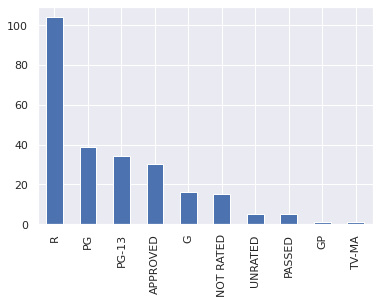

In [38]:
df['Rated'].value_counts().plot.bar()

In [6]:
rated_movies=df[df['Rated']=='R']

In [ ]:
df.count()

In [25]:
df.isna().sum()

Unnamed: 0             0
Title                  0
Year                   0
Rated                  0
Released               0
Runtime                0
Genre                  0
Director               0
Writer                 1
Actors                 0
Plot                   0
Language               0
Country                0
Awards                 5
Poster                 0
Ratings.Source         0
Ratings.Value          0
Metascore             73
imdbRating             0
imdbVotes              0
imdbID                 0
Type                   0
tomatoMeter          250
tomatoImage          250
tomatoRating         250
tomatoReviews        250
tomatoFresh          250
tomatoRotten         250
tomatoConsensus      250
tomatoUserMeter      250
tomatoUserRating     250
tomatoUserReviews    250
tomatoURL              0
DVD                    3
BoxOffice            175
Production             0
Website              119
Response               0
dtype: int64

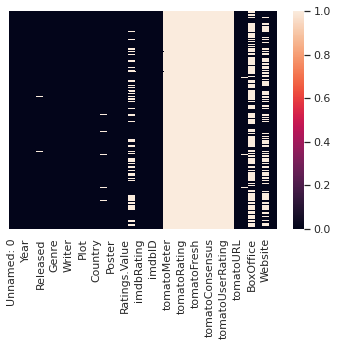

In [13]:
sns.heatmap(df.isnull(), yticklabels=False)

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [15]:
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
df['Released'] = df['Released'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df['Released'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(250, 124)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [16]:
#Since we have used the TF-IDF vectorizer, calculating the dot product will directly give us the cosine similarity score. 
#Therefore, we will use sklearn's linear_kernel() instead of cosine_similarities() since it is faster.
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [17]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(df.index, index=df['Title']).drop_duplicates()

In [18]:
# Function that takes in movie title as input and outputs most similar movies

def get_recommendations(Title, cosine_sim=cosine_sim):
    idx = indices[Title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df['Title'].iloc[movie_indices]


In [44]:
get_recommendations('Spider-Man: Homecoming')

203    Guardians of the Galaxy Vol. 2
197                              Lion
76                        Baby Driver
107                             Logan
25                       Interstellar
19              It's a Wonderful Life
235                          Magnolia
43                 The Great Dictator
92                         Unforgiven
241                    The Wild Bunch
Name: Title, dtype: object

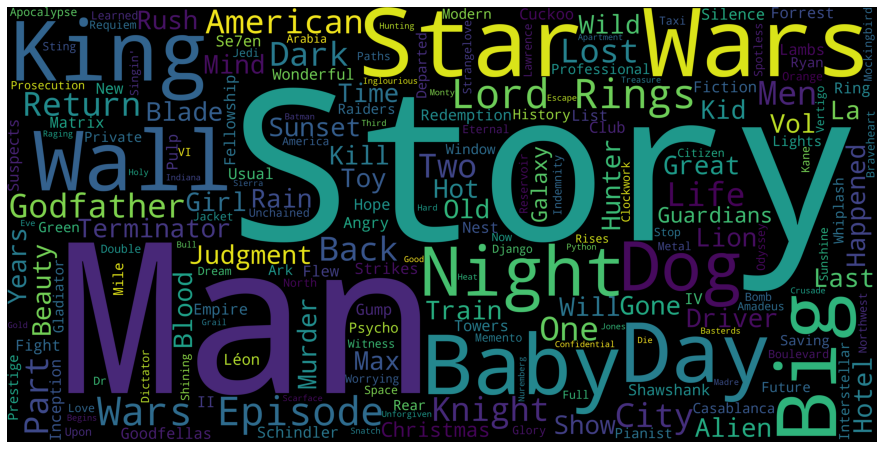

In [28]:
import matplotlib.pyplot as plt

%matplotlib inline
import wordcloud
from wordcloud import WordCloud, STOPWORDS

# Create a wordcloud of the movie titles
df['Title'] = df['Title'].fillna("").astype('str')
title_corpus = ' '.join(df['Title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

In [30]:
filledna=df.fillna('')

# Function to convert all strings to lower case and strip names of spaces to avoid duplication
def clean_data(x):
        return str.lower(x.replace(" ", ""))

In [31]:
 #Choosing the features that I want to base my recommendations on
 #Parse the stringified features into their corresponding python objects
features=['Title','Director','Rated','Actors','Awards']
filledna=filledna[features]

In [32]:
filledna.shape

(250, 5)

In [ ]:
for feature in features:
    filledna[feature] = filledna[feature].apply(clean_data)
    
filledna.head(2)

,Title,Director,Rated,Actors,Awards
0,theshawshankredemption,frankdarabont,r,"timrobbins,morganfreeman,bobgunton,williamsadler",nominatedfor7oscars.another19wins&30nominations.
1,thegodfather,francisfordcoppola,r,"marlonbrando,alpacino,jamescaan,richards.caste...",won3oscars.another23wins&27nominations.


In [ ]:
#We are now in a position to create our "metadata soup", which is a string that contains all the metadata that we want to feed to our vectorizer
def create_soup(x):
    return x['Title']+ ' ' + x['Director'] + ' ' + x['Rated'] + ' ' +x['Actors']+' '+ x['Awards']
filledna['soup'] = filledna.apply(create_soup, axis=1)

In [ ]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer
 #Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(filledna['soup'])

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [ ]:
filledna=filledna.reset_index()
indices = pd.Series(filledna.index, index=filledna['Title'])

In [ ]:
def get_recommendations_new(Title, cosine_sim=cosine_sim):
    Title=Title.replace(' ','').lower()
    idx = indices[Title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df['Title'].iloc[movie_indices]



In [ ]:
#let's test it by entering "The Dark Knight"
#these are the top 10 recommended movies (among the 250 available)
get_recommendations_new('The Dark Knight', cosine_sim2)

40                              The Prestige
89                             Batman Begins
51                     The Dark Knight Rises
25                              Interstellar
12                                 Inception
13     The Lord of the Rings: The Two Towers
203           Guardians of the Galaxy Vol. 2
165                   Spider-Man: Homecoming
10                              Forrest Gump
87        Indiana Jones and the Last Crusade
Name: Title, dtype: object